In [1]:
Pkg.checkout("LowRankModels")
using LowRankModels, PyPlot

INFO: Checking out LowRankModels master...
INFO: Pulling LowRankModels latest master...
INFO: No packages to install, update or remove


LowRankModels.jl is a julia package for modeling and fitting generalized low rank models (GLRMs). GLRMs model a data array by a low rank matrix, and include many well known models in data analysis, such as principal components analysis (PCA), matrix completion, robust PCA, nonnegative matrix factorization, k-means, and many more.

LowRankModels.jl makes it easy to mix and match loss functions and regularizers to construct a model suitable for a particular data set. In particular, it supports

   * using different loss functions for different columns of the data array, which is useful when data types are heterogeneous (eg, real, boolean, and ordinal columns);
   * fitting the model to only some of the entries in the table, which is useful for data tables with many missing (unobserved) entries; and
   * adding offsets and scalings to the model without destroying sparsity, which is useful when the data is poorly scaled.


# Losses

Supported losses include:
   * quadratic loss - QuadLoss()
   * hinge loss - HingeLoss()
   * logistic loss - LogisticLoss()
   * poisson loss - PoissonLoss()
   * weighted hinge loss - WeightedHingeLoss()
   * l1 loss - L1Loss()
   * ordinal hinge loss - OrdinalHingeLoss()
   * periodic loss - PeriodicLoss()
   * multinomial categorical loss - MultinomialLoss()
   * multinomial ordinal (aka ordered logit) loss - OrderedMultinomialLoss()

In [2]:
# loss function
loss = QuadLoss()

LowRankModels.QuadLoss(1.0,LowRankModels.RealDomain())

In [7]:
# the quad loss returns the sum of square differences between its first and second argument
evaluate(loss, 2., 3.)

1.0

In [6]:
# can scale the loss by any factor
evaluate(3*loss, 2., 3.)

3.0

In [12]:
evaluate(2*loss, [1., 1.], [3., 3.])

16.0

In [13]:
# can also evaluate the gradient wrt the first argument
grad(loss, 2., 0.)

4.0

In [16]:
grad(loss, [2., 0.], [0., 2.])

2-element Array{Float64,1}:
  4.0
 -4.0

In [8]:
grad(L1Loss(), [2., 0.], [0., 2.])

2-element Array{Float64,1}:
  1.0
 -1.0

# Regularizer

Supported regularizers include:

   * quadratic regularization - QuadReg()
   * constrained squared euclidean norm - QuadConstraint()
   * l1 regularization - OneReg()
   * no regularization - ZeroReg()
   * nonnegative constraint - NonNegConstraint() (eg, for nonnegative matrix factorization)
   * 1-sparse constraint - OneSparseConstraint() (eg, for orthogonal NNMF)
   * unit 1-sparse constraint - UnitOneSparseConstraint() (eg, for k-means)
   * simplex constraint - SimplexConstraint()
   * l1 regularization, combined with nonnegative constraint - NonNegOneReg()
   * fix features at values y0 - FixedLatentFeaturesConstraint(y0)

In [18]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

LowRankModels.QuadReg(1.0)

In [19]:
# can evaluate the proximal operator of the regularizer
prox(nonneg, -1)

0

In [20]:
prox(nonneg, 10)

10

In [21]:
prox(nonneg, [-5, -1, 0, 1, 5])

5-element Array{Int64,1}:
 0
 0
 0
 1
 5

In [22]:
# can evaluate the proximal operator of lambda times the regularizer
λ = .01
prox(l1, 1, λ)

0.99

In [23]:
# chain rule: 
# gradient of ||Xw - y||^2 wrt w is X' * <gradient of ||z-y||^2 wrt z>, 
# where z = X*w

We can use these to easily run proximal gradient on any combination of loss function and regularizers.

In [10]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 18 methods)

In [11]:
# proximal gradient method
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 1 method)

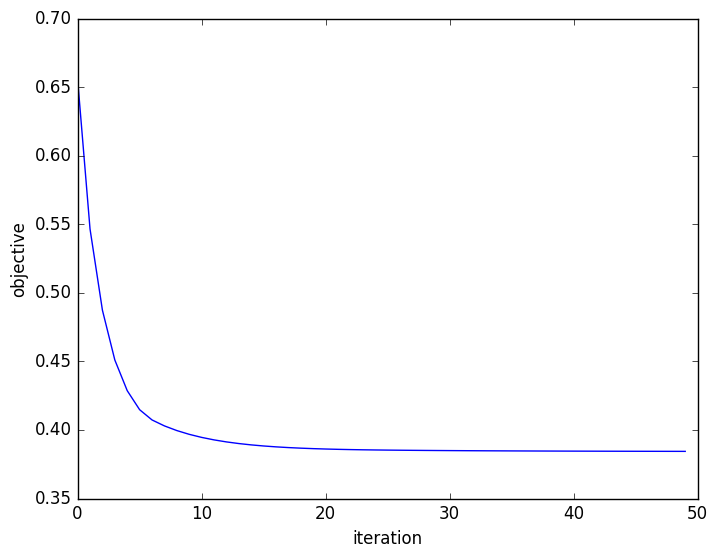

PyObject <matplotlib.text.Text object at 0x000000001C3AA748>

In [13]:
srand(0)
X, y = rand(6,3), rand(6);
ch = ConvergenceHistory("NNLS")
w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; 
             stepsize=.1, maxiters=50,
             ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

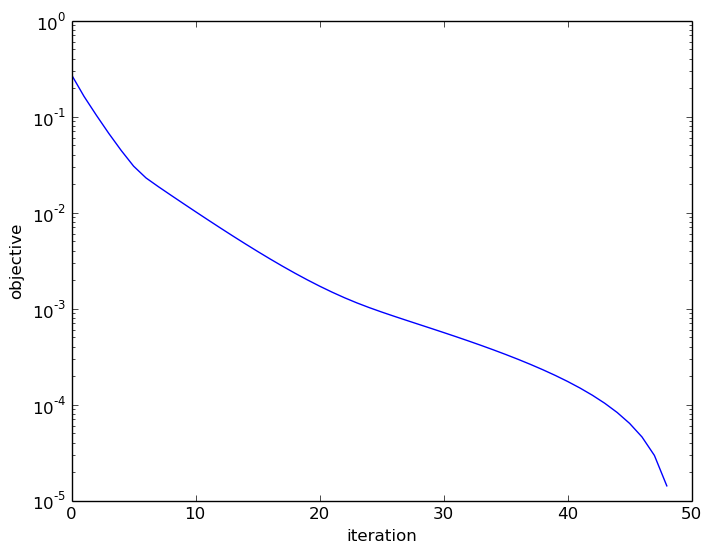

PyObject <matplotlib.text.Text object at 0x7f67680190d0>

In [30]:
semilogy(ch.objective - ch.objective[end])
xlabel("iteration")
ylabel("objective")

# Generalized Low Rank Models

GLRMs form a low rank model for tabular data A with m rows and n columns, which can be input as an array or any array-like object (for example, a data frame). It is fine if only some of the entries have been observed (i.e., the others are missing or NA); the GLRM will only be fit on the observed entries obs.

The desired model is specified by choosing a rank k for the model, an array of loss functions losses, and two regularizers, $r_x$ and $r_w$. The data is modeled as $X^TW$, where $X$ is a $k\times m$ matrix and $W$ is a $k\times n$ matrix. $X$ and $W$ are found by solving the optimization problem

$$\min \sum_{(i,j) \in obs} loss_j\bigg((X^TW)[i,j], Y[i,j]\bigg) + \sum_i r_x(X[:,i]) + \sum_j r_y(W[:,j])$$

To form a GLRM, the user specifies

   * the data $Y$ (any AbstractArray, such as an array, a sparse matrix, or a data frame)
   * the array of loss functions losses
   * the regularizers $r_x$ and $r_w$
   * the rank $k$


In [51]:
# example
Y = randn(10, 5)
for i in 1:10
    Y[i,5] =floor(2*rand())
end

for i in 1:10
        if (Y[i,5] ==1)
            Y[i,5] = true
        else
            Y[i,5]=false
        end
end

Y = convert(Array{Int64}, Y[:,5])

@show Y

Y = [-0.364316 0.48621 0.529893 -0.681469 1.0; -1.09471 0.427726 -0.295155 -1.59471 0.0; 1.21071 0.361468 1.38651 0.111892 1.0; 1.12624 -0.366335 -0.224418 1.11271 1.0; -1.46001 1.40364 0.238541 -0.38294 1.0; 2.40781 0.51368 0.863094 0.287128 1.0; -0.282661 1.17073 0.413762 1.27757 1.0; -1.27149 -0.274213 -0.236281 -0.57048 1.0; 0.460044 1.29301 -0.353405 -0.268516 0.0; -1.61891 -0.78491 -0.328808 -0.256936 1.0]


10×5 Array{Float64,2}:
 -0.364316   0.48621    0.529893  -0.681469  1.0
 -1.09471    0.427726  -0.295155  -1.59471   0.0
  1.21071    0.361468   1.38651    0.111892  1.0
  1.12624   -0.366335  -0.224418   1.11271   1.0
 -1.46001    1.40364    0.238541  -0.38294   1.0
  2.40781    0.51368    0.863094   0.287128  1.0
 -0.282661   1.17073    0.413762   1.27757   1.0
 -1.27149   -0.274213  -0.236281  -0.57048   1.0
  0.460044   1.29301   -0.353405  -0.268516  0.0
 -1.61891   -0.78491   -0.328808  -0.256936  1.0

In [48]:

loss = Loss[QuadLoss(),  QuadLoss(), QuadLoss(), QuadLoss(), HuberLoss()]
nonneg = NonNegConstraint()
k = 5
glrm = GLRM(Y, loss, nonneg, nonneg, k);

In [49]:
# To fit the model, call
X,W,ch = fit!(glrm)
@show ch.objective

Fitting GLRM
Iteration 10: objective value = 37.69302131282186
Iteration 20: objective value = 36.90474837998181
Iteration 30: objective value = 36.831340943883994
Iteration 40: objective value = 36.78111230705925
ch.objective = [Inf,130.722,48.8221,43.9616,42.1209,41.3406,40.677,39.9931,39.2212,38.4504,37.693,37.0995,36.9917,36.9782,36.9653,36.9539,36.9431,36.933,36.9232,36.9141,36.9047,36.8969,36.8884,36.8807,36.8726,36.8652,36.8578,36.8506,36.8439,36.8374,36.8313,36.8254,36.8197,36.8143,36.8092,36.8039,36.7988,36.7941,36.7903,36.7855,36.7811,36.777,36.7727,36.7687,36.7648,36.7621]


46-element Array{Float64,1}:
 Inf     
 130.722 
  48.8221
  43.9616
  42.1209
  41.3406
  40.677 
  39.9931
  39.2212
  38.4504
  37.693 
  37.0995
  36.9917
   ⋮     
  36.8092
  36.8039
  36.7988
  36.7941
  36.7903
  36.7855
  36.7811
  36.777 
  36.7727
  36.7687
  36.7648
  36.7621

This runs an alternating directions proximal gradient method on glrm to find the $X$ and $W$ minimizing the objective function.

In [47]:
X

5×10 Array{Float64,2}:
 0.17911   0.0       0.496128   0.0       …  0.0       0.20934  0.0     
 0.0       0.0       0.0        0.0          0.716636  0.0      0.0     
 0.0       0.0       0.937744   0.894573     0.0       0.0      0.0     
 0.138866  0.144994  0.0        0.0          0.0       0.0      0.498131
 0.207031  1.05406   0.0778759  0.0          0.0       0.0      0.0     

In [48]:
W

5×10 Array{Float64,2}:
 0.0     0.0      0.0  3.63005  0.0       …  0.0       0.0       2.71933 
 1.1131  0.338    0.0  0.0      0.302205     0.723267  0.706002  0.429418
 0.0     1.77839  0.0  0.0      0.0          0.0       0.0       0.044501
 0.0     0.0      0.0  0.0      0.0          2.35205   2.52362   0.0     
 0.0     0.0      0.0  0.0      0.0          0.0       0.0       0.373565

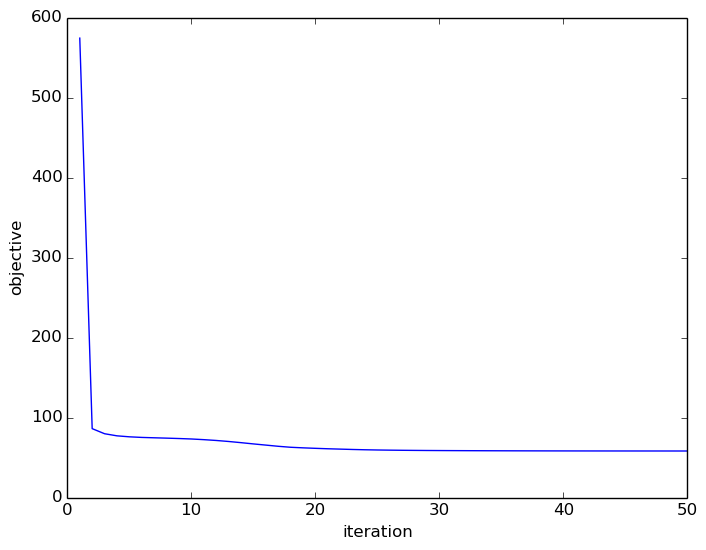

PyObject <matplotlib.text.Text object at 0x7f6767ef8110>

In [50]:
plot(ch.objective)
xlabel("iteration")
ylabel("objective")

The losses argument can also be an array of loss functions, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [47]:
losses = Loss[QuadLoss(), LogisticLoss(), HingeLoss()]

3-element Array{LowRankModels.Loss,1}:
 LowRankModels.QuadLoss(1.0,LowRankModels.RealDomain())             
 LowRankModels.LogisticLoss(1.0,LowRankModels.BoolDomain())         
 LowRankModels.WeightedHingeLoss(1.0,LowRankModels.BoolDomain(),1.0)

Similiarly, the $r_w$ argument can be an array of regularizers, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [54]:
rw = Regularizer[QuadReg(1), QuadReg(10), OneReg()]

3-element Array{LowRankModels.Regularizer,1}:
 LowRankModels.QuadReg(1.0) 
 LowRankModels.QuadReg(10.0)
 LowRankModels.OneReg(1.0)  

Example: PCA

In [55]:
# minimize ||Y - XW||^2
function fit_pca(m,n,k)
	# matrix to encode
	Y = randn(m,k)*randn(k,n)
	loss = QuadLoss()
	r = ZeroReg()
	glrm = GLRM(Y,loss,r,r,k)
	X,W,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return Y,X,W,ch
end

fit_pca (generic function with 1 method)